In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
#https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
import numpy as np
import re
import matplotlib.pyplot as plt

df = pd.read_csv('original_dataset.csv', low_memory = False, dtype = {'locality': str, 'postcode': str, 'property_subtype': str})
raw_df = df

In [2]:
df = df[['locality', 'postcode', "property_subtype", "price", "area"]]
regex = "[0-9]{4}"
df = df[df.postcode.str.match(regex, na=False)|df.locality.str.match(regex, na=False)]

In [3]:
#Extraction of useful data from locality field
def extract_address(d): 
    return re.sub("(([A-Za-z0-9àâçéèêëîïôûùüÿñæœ .-]*)(,{0,} {0,})(\d{4})([A-Za-zàâçéèêëîïôûùüÿñæœ .-]*)(,{0,} {0,})([A-Za-zàâçéèêëîïôûùüÿñæœ .-]*)|([A-ZÂÀÃÉÈÊÛa-zàâçéèêëîïôûùüÿñæœ'\-\/ \(\)]*)([0-9]{1})|([A-ZÂÀÃÉÈÊÛa-zàâçéèêëîïôûùüÿñæœ&',\.\-\/ \(\)]*))", r'\2',d)
def extract_postcode(d): 
    return re.sub("(([A-Za-z0-9àâçéèêëîïôûùüÿñæœ .-]*)(,{0,} {0,})(\d{4})([A-Za-zàâçéèêëîïôûùüÿñæœ .-]*)(,{0,} {0,})([A-Za-zàâçéèêëîïôûùüÿñæœ .-]*)|([A-ZÂÀÃÉÈÊÛa-zàâçéèêëîïôûùüÿñæœ'\-\/ \(\)]*)([0-9]{1})|([A-ZÂÀÃÉÈÊÛa-zàâçéèêëîïôûùüÿñæœ&',\.\-\/ \(\)]*))", r'\4',d)
def extract_locality(d): 
    return re.sub("(([A-Za-z0-9àâçéèêëîïôûùüÿñæœ .-]*)(,{0,} {0,})(\d{4})([A-Za-zàâçéèêëîïôûùüÿñæœ .-]*)(,{0,} {0,})([A-Za-zàâçéèêëîïôûùüÿñæœ .-]*)|([A-ZÂÀÃÉÈÊÛa-zàâçéèêëîïôûùüÿñæœ'\-\/ \(\)]*)([0-9]{1})|([A-ZÂÀÃÉÈÊÛa-zàâçéèêëîïôûùüÿñæœ&',\.\-\/ \(\)]*))", r'\5',d)

#df['extracted_address'] = df[~df['locality'].isnull()]['locality'].apply(extract_address)
df['extracted_postcode'] = df[~df['locality'].isnull()]['locality'].apply(extract_postcode)
#df['extracted_locality'] = df[~df['locality'].isnull()]['locality'].apply(extract_locality)

In [4]:
df['merged_postcode'] = df['postcode'].replace(np.nan, '') + df['extracted_postcode'].replace(np.nan, '')
def unmerge_postcode(d): 
    return re.sub("(\d{4}){0,1}(\d{4})$", r'\2', d)
df['unmerged_postcode'] = df[~df['merged_postcode'].isnull()]['merged_postcode'].apply(unmerge_postcode)

In [5]:
regex = '^\d{4}$'
df[~df.unmerged_postcode.str.match(regex, na = False)]

,locality,postcode,property_subtype,price,area,extracted_postcode,merged_postcode,unmerged_postcode
65926,"§S Gravenwezel, Schilde",2970,VILLA,1250000.0,446.0,§,2970§,2970§
66678,Court-Saint-©tienne,1490,HOUSE,399000.0,165.0,©,1490©,1490©


In [6]:
regex = '^\d{4}$'
df = df.drop(df[~df.unmerged_postcode.str.match(regex, na = False)].index)

In [7]:
df = df.drop(['locality', 'postcode', 'extracted_postcode', 'merged_postcode'], axis=1, errors='ignore')

In [8]:
regex = '^(10|11|12)\d{2}$'
df = df.drop(df[~df.unmerged_postcode.str.match(regex, na = False)].index)

In [9]:
df['property_subtype']=np.where(df.property_subtype.str.match('[A-Za-zàâçéèêëîïôûùüÿñæœ]*'),df['property_subtype'].str.upper(),np.nan)

In [10]:
df = df.drop(df[df['price'].isnull()].index)
df = df.drop(df[df['area'].isnull()].index)
df = df.drop(df[df['price'] == 'None'].index)
df = df.drop(df[df['price'] == '@0'].index)
df = df.drop(df[df['area'] == 'None'].index)
df = df.drop(df[df['area'] == 'Not specified'].index)

In [11]:
def clean_price(d): 
    return re.sub("^(€{0,})(([0-9\,\.])+)(€{0,})$", r'\2',d)
df['price'] = df['price'].apply(clean_price)

In [12]:
def clean_weird_price(d): 
    return re.sub("^(([0-9\,\.])+)(€{1} {1})(([0-9\,\.])+)$", r'\1',d)
df['price'] = df['price'].apply(clean_weird_price)

In [13]:
def clean_point(d): 
    return re.sub('^(([0-9])+)([\.]{1})([0]{1})$', r'\1', d)
df['price'] = df['price'].apply(clean_point)

In [14]:
def clean_comma(d): 
    return re.sub('^(([0-9]){0,2})([\,]{0,})(([0-9])+)([\,]{1})(([0-9])+)$', r'\1\3\5', d)
df['price'] = df['price'].apply(clean_comma)

In [15]:
def clean_zero(d): 
    return re.sub('^(([0-9])+)([\,]{1})$', r'\1000', d)
df['price'] = df['price'].apply(clean_zero)

In [16]:
def clean_million(d): 
    return re.sub('^(([0-9]){1})([\,]{1})(([0-9]){1})$', r'\1\300000', d)
df['price'] = df['price'].apply(clean_million)

In [17]:
def clean_area(d): 
    return re.sub('^([0-9]+)( {0,}m{0,}²{0,})', r'\1',d)
df['area'] = df['area'].apply(clean_area)

In [18]:
df = df.drop(df[df['price'] == '1À000'].index)
df = df.drop(df[df['price'] == '2À000'].index)
df = df.drop(df[df['price'] == '3À000'].index)

In [19]:
df = df.drop(df[df['price'] == '23456789'].index)

In [20]:
df['price'] = pd.to_numeric(df['price'])
df['area'] = pd.to_numeric(df['area'])

In [21]:
df = df.drop(df[df['area']>600].index)

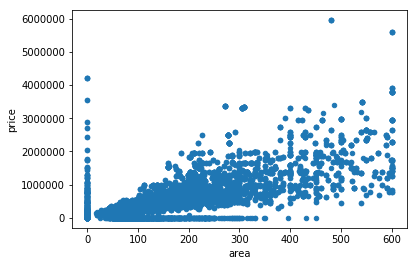

In [22]:
df.plot.scatter(x = 'area', y = 'price')

In [23]:
sorted(df['unmerged_postcode'].unique())

['1000',
 '1020',
 '1030',
 '1040',
 '1044',
 '1050',
 '1060',
 '1070',
 '1080',
 '1081',
 '1082',
 '1083',
 '1090',
 '1120',
 '1130',
 '1140',
 '1150',
 '1160',
 '1170',
 '1180',
 '1190',
 '1200',
 '1210',
 '1212']

In [24]:
df[df['unmerged_postcode']=='1212']

,property_subtype,price,area,unmerged_postcode
91534,NaN,335000,89.0,1212


In [25]:
df = df.drop(df[df['unmerged_postcode'] == '1212'].index)
df = df.drop(df[df['unmerged_postcode'] == '1044'].index)

In [26]:
df.head()

,property_subtype,price,area,unmerged_postcode
3,HOUSE,545000,235.0,1200
4,MIXED_USE_BUILDING,500000,220.0,1190
7,APARTMENT_BLOCK,650000,200.0,1150
11,APARTMENT_BLOCK,399000,137.0,1030
14,APARTMENT_BLOCK,1750000,550.0,1200


In [27]:
df_pc = pd.read_csv('postcodes.csv')

In [28]:
#type(df['unmerged_postcode'][2])
#NOT WORKING
#type(df_pc['postcode'][1]) 
#WORKING

In [29]:
df['unmerged_postcode'] = pd.to_numeric(df['unmerged_postcode'])
df = df.set_index('unmerged_postcode').join(df_pc.set_index('postcode'))

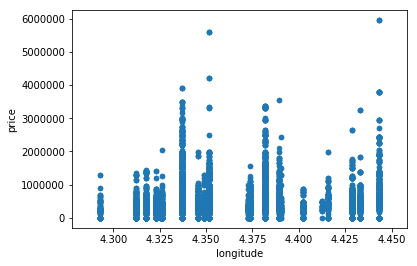

In [30]:
df.plot.scatter(x = 'longitude', y = 'price')

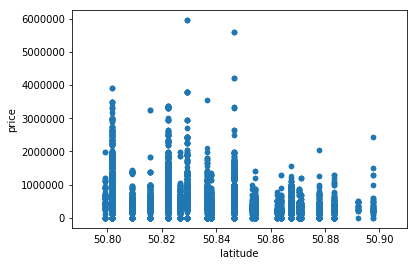

In [31]:
df.plot.scatter(x = 'latitude', y = 'price')

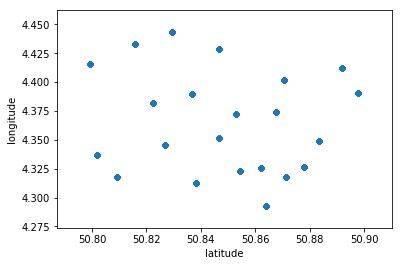

In [32]:
df.plot.scatter(x = 'latitude', y = 'longitude')

In [33]:
df_backup = df

In [34]:
df_backup.head()

,property_subtype,price,area,locality,longitude,latitude
1000,MIXED_USE_BUILDING,1395000,568.0,Bruxelles,4.351697,50.846557
1000,MIXED_USE_BUILDING,1475000,260.0,Bruxelles,4.351697,50.846557
1000,MIXED_USE_BUILDING,1600000,300.0,Bruxelles,4.351697,50.846557
1000,APARTMENT_BLOCK,1350000,400.0,Bruxelles,4.351697,50.846557
1000,MIXED_USE_BUILDING,1500000,521.0,Bruxelles,4.351697,50.846557


In [35]:
df = df_backup

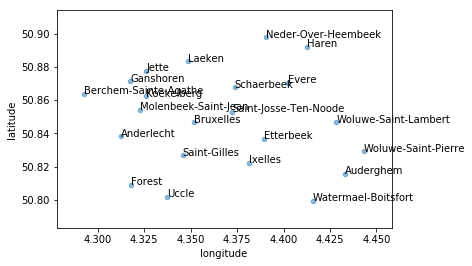

In [36]:
import pandas as pd 
from matplotlib import pyplot as plt 

ax = df_pc.plot.scatter(x='longitude', y='latitude', alpha=0.5)
for i, txt in enumerate(df_pc.locality):
    ax.annotate(txt, (df_pc.longitude.iat[i],df_pc.latitude.iat[i]))
plt.show()


In [37]:
df.head()

,property_subtype,price,area,locality,longitude,latitude
1000,MIXED_USE_BUILDING,1395000,568.0,Bruxelles,4.351697,50.846557
1000,MIXED_USE_BUILDING,1475000,260.0,Bruxelles,4.351697,50.846557
1000,MIXED_USE_BUILDING,1600000,300.0,Bruxelles,4.351697,50.846557
1000,APARTMENT_BLOCK,1350000,400.0,Bruxelles,4.351697,50.846557
1000,MIXED_USE_BUILDING,1500000,521.0,Bruxelles,4.351697,50.846557


In [38]:
# Linear Regression

from sklearn import model_selection
from sklearn.linear_model import LinearRegression

dataframe = df.drop(['property_subtype', 'locality'], axis=1, errors='ignore')

In [39]:
dataframe.head()

,price,area,longitude,latitude
1000,1395000,568.0,4.351697,50.846557
1000,1475000,260.0,4.351697,50.846557
1000,1600000,300.0,4.351697,50.846557
1000,1350000,400.0,4.351697,50.846557
1000,1500000,521.0,4.351697,50.846557


In [54]:
predicted = dataframe['price']
predictor = dataframe.loc[:, dataframe.columns == 'area']
model = LinearRegression().fit(predictor, predicted)
r_sq = model.score(predictor, predicted)

In [55]:
r_sq

0.5329414841885775

In [56]:
model.intercept_

-7501.153385862475

In [57]:
model.coef_

array([3595.34530609])

In [61]:
y_pred = model.predict(predictor)

In [62]:
y_pred

array([1907165.07331637,  852288.7371439 ,  989285.66391954, ...,
        321816.36064649,  256742.82042807,  239618.20458111])

In [63]:
predicted = dataframe['price']
predictor = dataframe.loc[:, dataframe.columns != 'price']
model = LinearRegression().fit(predictor, predicted)
r_sq = model.score(predictor, predicted)